# **Chapter 7**
## *Handling Missing Data*, 

This chapter explores different methods for identifying and handling missing data. You will learn different imputation and interpolation techniques. The chapter starts with simple statistical methods for univariate imputation and then explores various univariate interpolation algorithms for more advanced multivariate imputation.

In this chapter, you will explore techniques to handle missing data through **imputation** and **interpolation**.  

Here is the list of recipes that we will cover in this chapter:
* Performing data quality checks
* Handling missing data with univariate imputation using pandas
* Handling missing data with univariate imputation using scikit-learn
* Handling missing data with multivariate imputation
* Handling missing data with interpolation

# Technical Requirements
* In this chapter, two datasets will be used extensively for the imputation and interpolation recipes: 
    * the CO2 Emissions dataset, and the e-Shop Clickstream dataset. The source for the Clickstream dataset comes from clickstream data for online shopping from the UCI machine learning repository, which you can find here: https://archive.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping
    * The source for the CO2 emissions dataset comes from the Annual CO2 emissions report from Our World in Data, which you can find here: https://ourworldindata.org/ co2-emissions.

### Run These First

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# from matplotlib.patches import Rectangle
# import matplotlib.dates as mdates


* If you are using __pip__, then you can install these packages from your terminal with the following command:

```
pip install matplotlib numpy statsmodels scikit-learn scipy
```

* If you are using __conda__, then you can install these packages with the following command:

```
conda install matplotlib numpy statsmodels scikit-learn scipy
```

In [4]:
import matplotlib
import sklearn
import statsmodels as sm
import scipy

print(f'''
pandas -> {pd.__version__}
numpy -> {np.__version__}
matplotlob -> {matplotlib.__version__}
statsmodels -> {sm.__version__}
scikit-learn -> {sklearn.__version__}
scipy -> {scipy.__version__}
''')


pandas -> 2.2.3
numpy -> 2.2.2
matplotlob -> 3.10.0
statsmodels -> 0.14.4
scikit-learn -> 1.6.1
scipy -> 1.15.1



In [6]:
plt.style.use('grayscale')
plt.rc("figure", figsize=(16, 5))

## Preparing for the recipes of this chapter

## Functions used
* Create all necessary functions that will be used
### `read_datesets()`

In [10]:
def read_dataset(folder, file, date_col=None, format=None, index=False):
    '''
    folder: is a Path object
    file: the CSV filename in that Path object. 
    date_col: specify a column which has datetime
    index_col: True if date_col should be the index
    
    returns: a pandas DataFrame with a DatetimeIndex
    '''
    index_col = date_col if index is True else None
    
    df = pd.read_csv(folder / file, 
                     index_col=index_col, 
                     parse_dates=[date_col],
                     date_format=format)
    return df


### `plot_dfs()`

In [13]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''	
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)
    
    # subplots_size = df2.shape[1]
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    fig.suptitle = title 
    
    df1[col].plot(ax=ax[0], figsize=(12, 10))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname)
    
    fig.tight_layout()
    plt.show()


### `rmse_score()`

In [16]:
def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data

    returns: a list of scores
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores


# Recipe 1: Perform Data Quality Checks
* Examples of missing data
* Understand `NaN` vs `NaT`
* Identify missing observations that are replaced with other values in the source system but should be considered as missing
* Explain `na_values` and `keep_default_na` parameters 

In [19]:
folder = Path('../../datasets/Ch7/')
co2_file = Path('co2_missing.csv')
ecom_file = Path('clicks_missing_multiple.csv')

co2_df = read_dataset(folder, 
                      co2_file, 
                      index=True, 
                      date_col='year')
ecom_df = read_dataset(folder, 
                       ecom_file, 
                       index=True, 
                       date_col='date')

In [21]:
# co2 = Path('../../datasets/Ch7/co2_missing.csv')
# ecom = Path('../../datasets/Ch7/clicks_missing_multiple.csv')
# co2_df = pd.read_csv(co2, parse_dates=['year'])
# ecom_df = pd.read_csv(ecom, parse_dates=['date'])

In [23]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 226 entries, 1750-01-01 to 2020-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     201 non-null    float64
dtypes: float64(1)
memory usage: 3.5 KB


In [29]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135 entries, 2008-04-01 to 2008-08-13
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     134 non-null    float64
 1   location  134 non-null    float64
 2   clicks    121 non-null    object 
dtypes: float64(2), object(1)
memory usage: 4.2+ KB


In [31]:
co2_df.shape

(226, 1)

In [33]:
ecom_df.shape

(135, 3)

In [35]:
co2_df.head()

,co2
year,
1750-01-01,0.0125
1760-01-01,0.0128
1770-01-01,0.0150
1780-01-01,0.0169
1790-01-01,0.0206


In [37]:
ecom_df.head()

,price,location,clicks
date,,,
2008-04-01,43.155647,2.0,18784
2008-04-02,43.079056,1.0,24738
NaT,43.842609,NaN,15209
NaT,NaN,1.0,14018
NaT,43.941176,1.0,11974


In [39]:
co2_df.head()

,co2
year,
1750-01-01,0.0125
1760-01-01,0.0128
1770-01-01,0.0150
1780-01-01,0.0169
1790-01-01,0.0206


In [41]:
co2_df.isnull().sum()

co2    25
dtype: int64

In [43]:
# using isna()
co2_df.isna().sum()

co2    25
dtype: int64

In [45]:
ecom_df.isna().sum()

price        1
location     1
clicks      14
dtype: int64

In [47]:
co2_df.reset_index(inplace=True)
ecom_df.reset_index(inplace=True)

In [49]:
co2_df.isna().sum()

year     0
co2     25
dtype: int64

In [51]:
ecom_df.isna().sum()

date         4
price        1
location     1
clicks      14
dtype: int64

In [53]:
# using isnull()
ecom_df.isnull().sum()

date         4
price        1
location     1
clicks      14
dtype: int64

In [55]:
# using isnull()
ecom_df.isnull().sum().sum()

np.int64(20)

In [57]:
co2_df.isnull().sum().sum()

np.int64(25)

In [59]:
print(co2_df[190:195])

          year     co2
190 1985-01-01     NaN
191 1986-01-01     NaN
192 1987-01-01     NaN
193 1988-01-01  4.2953
194 1989-01-01  4.2782


In [61]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [63]:
ecom_df.isnull().values.any()

np.True_

In [65]:
co2_df.isnull().values.any()

np.True_

In [67]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [69]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   year    226 non-null    datetime64[ns]
 1   co2     201 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.7 KB


In [71]:
co2_df.describe(include='all')

,year,co2
count,226,201.000000
mean,1906-11-27 01:29:12.212389376,1.590015
min,1750-01-01 00:00:00,0.000000
25%,1851-04-02 06:00:00,0.076400
50%,1907-07-02 12:00:00,0.935100
75%,1963-10-01 18:00:00,2.807600
max,2020-01-01 00:00:00,4.907900
std,NaN,1.644182


In [73]:
ecom_df.describe(include='all')

,date,price,location,clicks
count,131,134.000000,134.000000,121
unique,NaN,NaN,NaN,119
top,NaN,NaN,NaN,?
freq,NaN,NaN,NaN,2
mean,2008-06-08 22:32:03.664122112,43.480221,1.694030,NaN
min,2008-04-01 00:00:00,42.207018,1.000000,NaN
25%,2008-05-07 12:00:00,43.038050,1.000000,NaN
50%,2008-06-09 00:00:00,43.498842,1.000000,NaN
75%,2008-07-11 12:00:00,43.889935,2.000000,NaN
max,2008-08-13 00:00:00,45.801613,5.000000,NaN


In [75]:
test = pd.read_csv(folder/ecom_file, parse_dates=['date'], na_values={'?'})
test

,date,price,location,clicks
0,2008-04-01,43.155647,2.0,18784.0
1,2008-04-02,43.079056,1.0,24738.0
2,NaT,43.842609,NaN,15209.0
3,NaT,NaN,1.0,14018.0
4,NaT,43.941176,1.0,11974.0
...,...,...,...,...
130,2008-08-09,44.182033,1.0,6716.0
131,2008-08-10,43.608260,1.0,9523.0
132,2008-08-11,43.553363,1.0,8881.0
133,2008-08-12,44.500469,1.0,7272.0


In [77]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [79]:
co2_df.replace(0, np.nan, inplace=True)
ecom_df.replace('?', np.nan, inplace=True)
ecom_df['clicks'] = ecom_df['clicks'].astype('float')

In [81]:
co2_df.isnull().sum()

year     0
co2     35
dtype: int64

In [83]:
ecom_df.isnull().sum()

date         4
price        1
location     1
clicks      16
dtype: int64

## How it works

In [86]:
co2_df = pd.read_csv(folder/co2_file, 
                     keep_default_na=False)

In [88]:
co2_df.iloc[132:139]

,year,co2
132,1927,
133,1928,
134,1929,
135,1930,
136,1931,
137,1932,
138,1933,


In [90]:
co2_df.iloc[132:139]['co2'] == ''

132    True
133    True
134    True
135    True
136    True
137    True
138    True
Name: co2, dtype: bool

In [92]:
co2_df.isna().sum()

year    0
co2     0
dtype: int64

In [94]:
co2_df.shape

(226, 2)

In [96]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    226 non-null    int64 
 1   co2     226 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.7+ KB


In [98]:
print(co2_df[190:195])

     year     co2
190  1985      NA
191  1986     N/A
192  1987    null
193  1988  4.2953
194  1989  4.2782


In [100]:
print(co2_df.iloc[132:139])

     year co2
132  1927    
133  1928    
134  1929    
135  1930    
136  1931    
137  1932    
138  1933    


In [102]:
co2_df.isnull().sum()
co2_df.isnull().sum().sum()

np.int64(0)

### There is More

In [105]:
ecom_df = pd.read_csv(folder/ecom_file, 
                      parse_dates=['date'], 
                      na_values={'?'})

In [107]:
ecom_df

,date,price,location,clicks
0,2008-04-01,43.155647,2.0,18784.0
1,2008-04-02,43.079056,1.0,24738.0
2,NaT,43.842609,NaN,15209.0
3,NaT,NaN,1.0,14018.0
4,NaT,43.941176,1.0,11974.0
...,...,...,...,...
130,2008-08-09,44.182033,1.0,6716.0
131,2008-08-10,43.608260,1.0,9523.0
132,2008-08-11,43.553363,1.0,8881.0
133,2008-08-12,44.500469,1.0,7272.0


In [109]:
ecom_df.isna().sum()

date         4
price        1
location     1
clicks      16
dtype: int64

# Recipe 2: Handling Missing Data with Univariate Imputation using pandas  

Some basic univariate imputation techniques include the following:
* Imputing using the mean.
* Imputing using the last observation forward (forward fill). This can be referred to as Last Observation Carried Forward (LOCF).
* Imputing using the next observation backward (backward fill). This can be referred to as Next Observation Carried Backward (NOCB).  

You will use two datasets to impute missing data using different techniques and then compare the results.

In [112]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [114]:
folder = Path('../../datasets/Ch7/')

co2_original = read_dataset(folder, 'co2_original.csv', 'year', index=True)
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year', index=True)
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date', index=True)


In [116]:
co2_missing.isnull().sum()

co2    35
dtype: int64

In [118]:
clicks_missing.isnull().sum()

price        0
location     0
clicks      16
dtype: int64

In [120]:
clicks_missing.loc[:, 'missing':].shape[1]

2

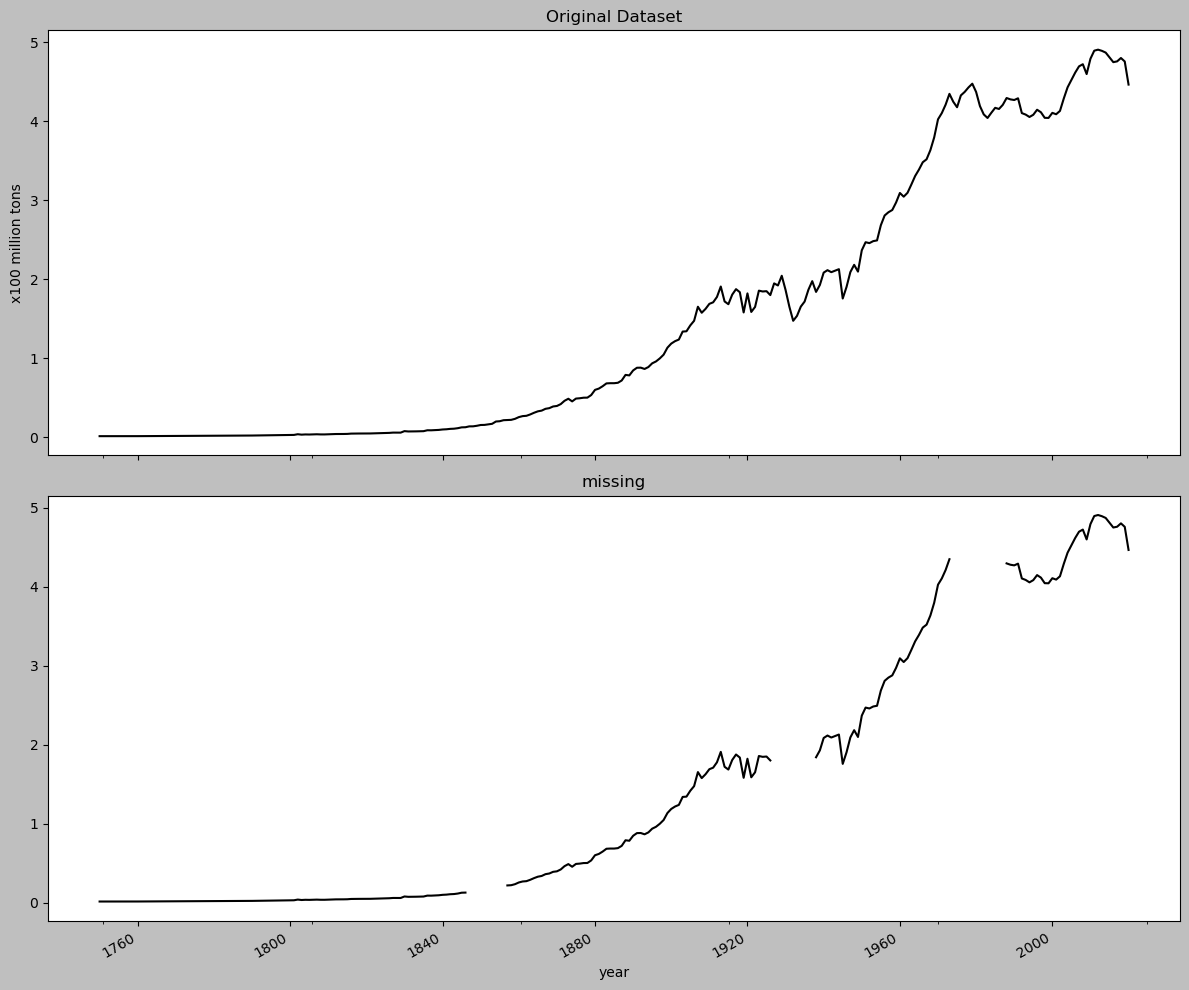

In [122]:
plot_dfs(co2_original, 
         co2_missing, 
         'co2',
         title="Annual CO2 Emission per Capita",
         xlabel="Years",
         ylabel="x100 million tons")

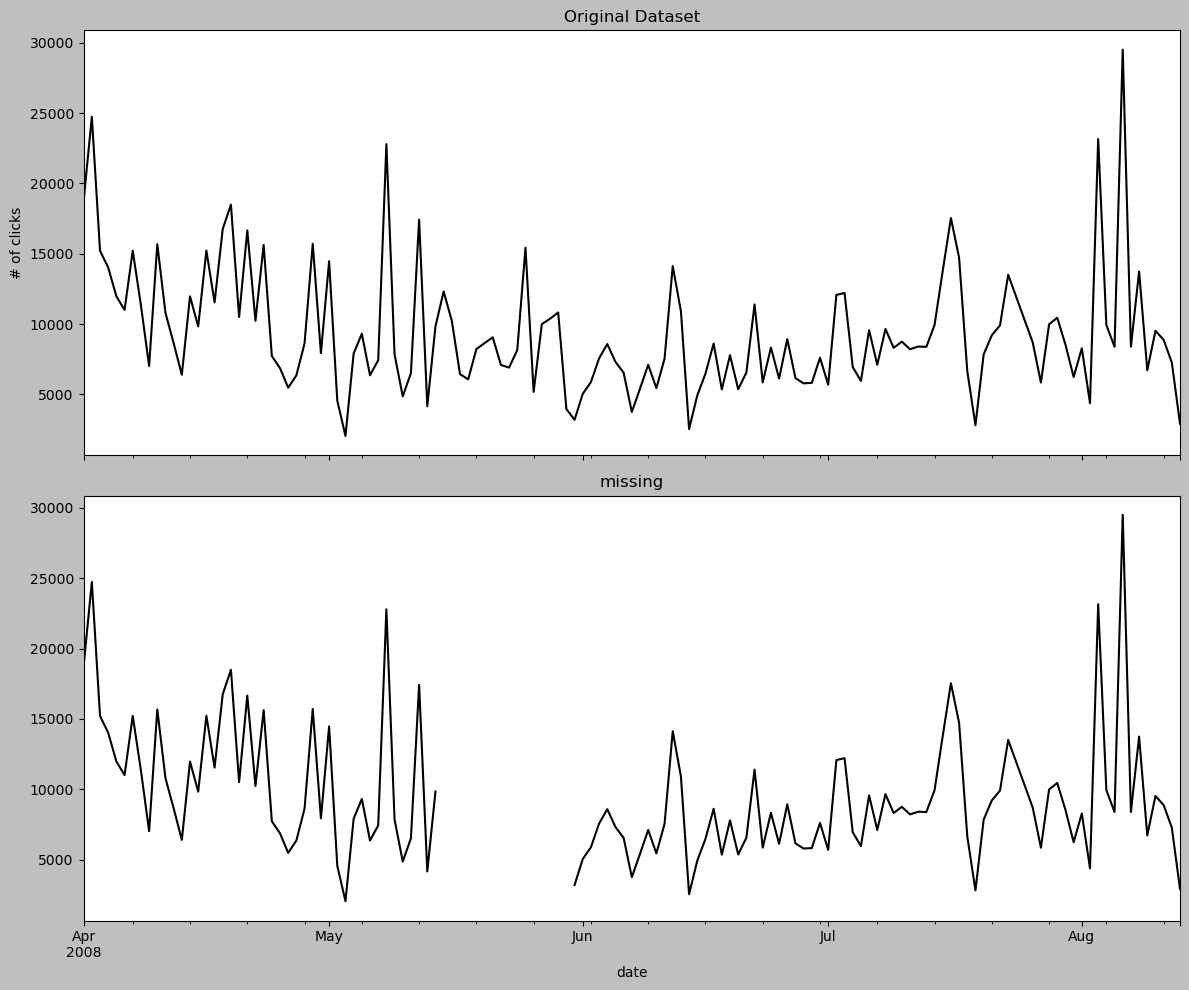

In [124]:
plot_dfs(clicks_original, 
         clicks_missing, 
         'clicks',
         title="Page Clicks per Day",
         xlabel="date",
         ylabel="# of clicks")

In [126]:
# Note - using the method options is deprecated as indicated in the below warning 
# co2_missing['ffill'] = co2_missing['co2'].fillna(method='ffill')
# co2_missing['bfill'] = co2_missing['co2'].fillna(method='bfill')
# co2_missing['mean'] = co2_missing['co2'].fillna(co2_missing['co2'].mean())

In [128]:
co2_missing['ffill'] = co2_missing['co2'].ffill()
co2_missing['bfill'] = co2_missing['co2'].bfill()
co2_missing['mean'] = co2_missing['co2'].fillna(co2_missing['co2'].mean())

In [130]:
_ = rmse_score(co2_original, 
                    co2_missing, 
                    'co2')

RMSE for ffill: 0.05873012599267133
RMSE for bfill: 0.05550012995280968
RMSE for mean: 0.7156383637041684


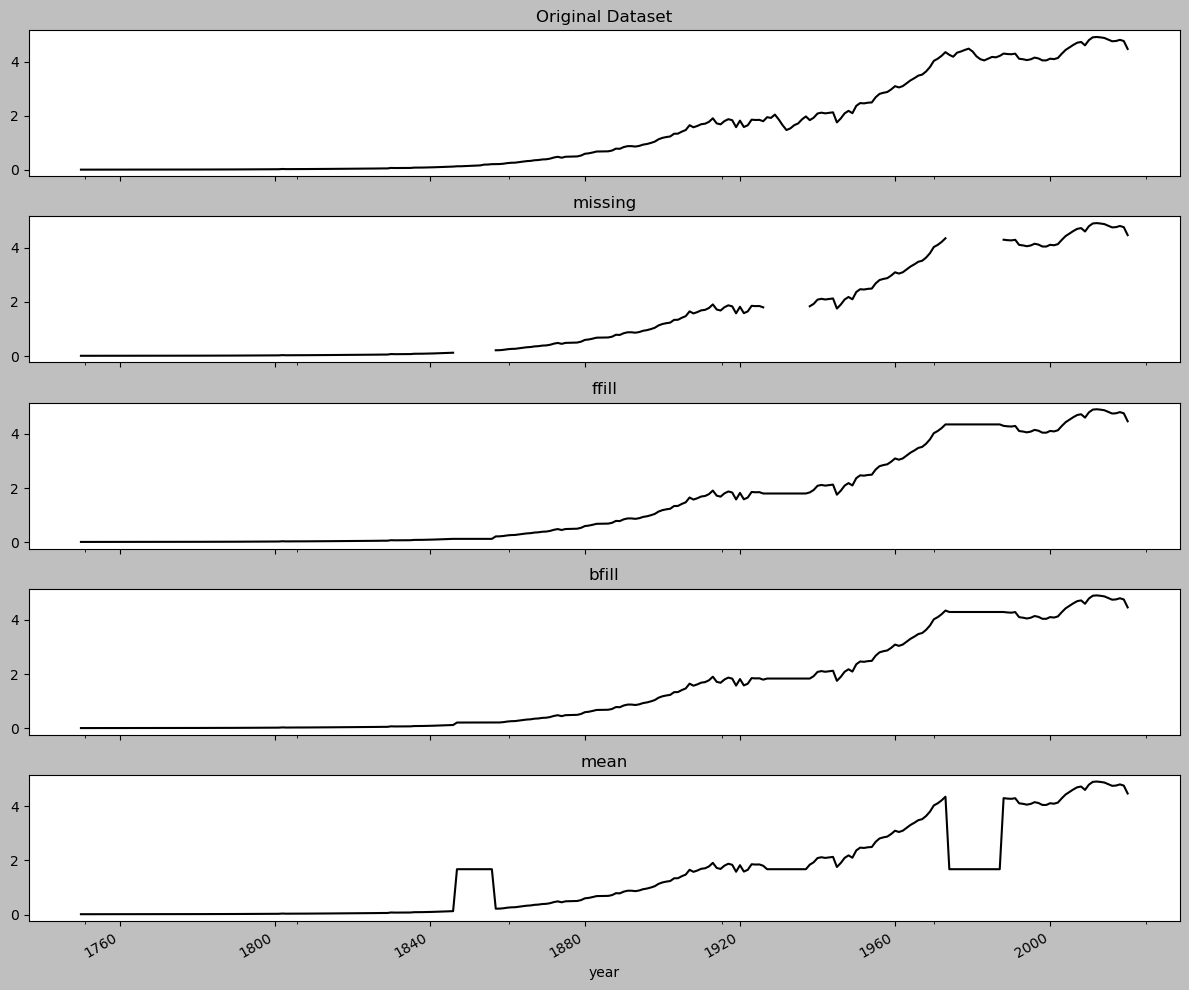

In [132]:
plot_dfs(co2_original, co2_missing, 'co2')

In [134]:
# Note - using the method options is deprecated as indicated in the below warning 
# clicks_missing['ffil'] = clicks_missing['clicks'].fillna(method='ffill')
# clicks_missing['bfill'] = clicks_missing['clicks'].fillna(method='bfill')
# clicks_missing['mean'] = clicks_missing['clicks'].fillna(clicks_missing['clicks'].mean())

In [136]:
clicks_missing['ffill'] = clicks_missing['clicks'].ffill()
clicks_missing['bfill'] = clicks_missing['clicks'].bfill()
clicks_missing['mean'] = clicks_missing['clicks'].fillna(clicks_missing['clicks'].mean())

In [138]:
_ = rmse_score(clicks_original, 
                    clicks_missing, 
                    'clicks')

RMSE for ffill: 1034.1210689204554
RMSE for bfill: 2116.6840489225033
RMSE for mean: 997.7600138929953


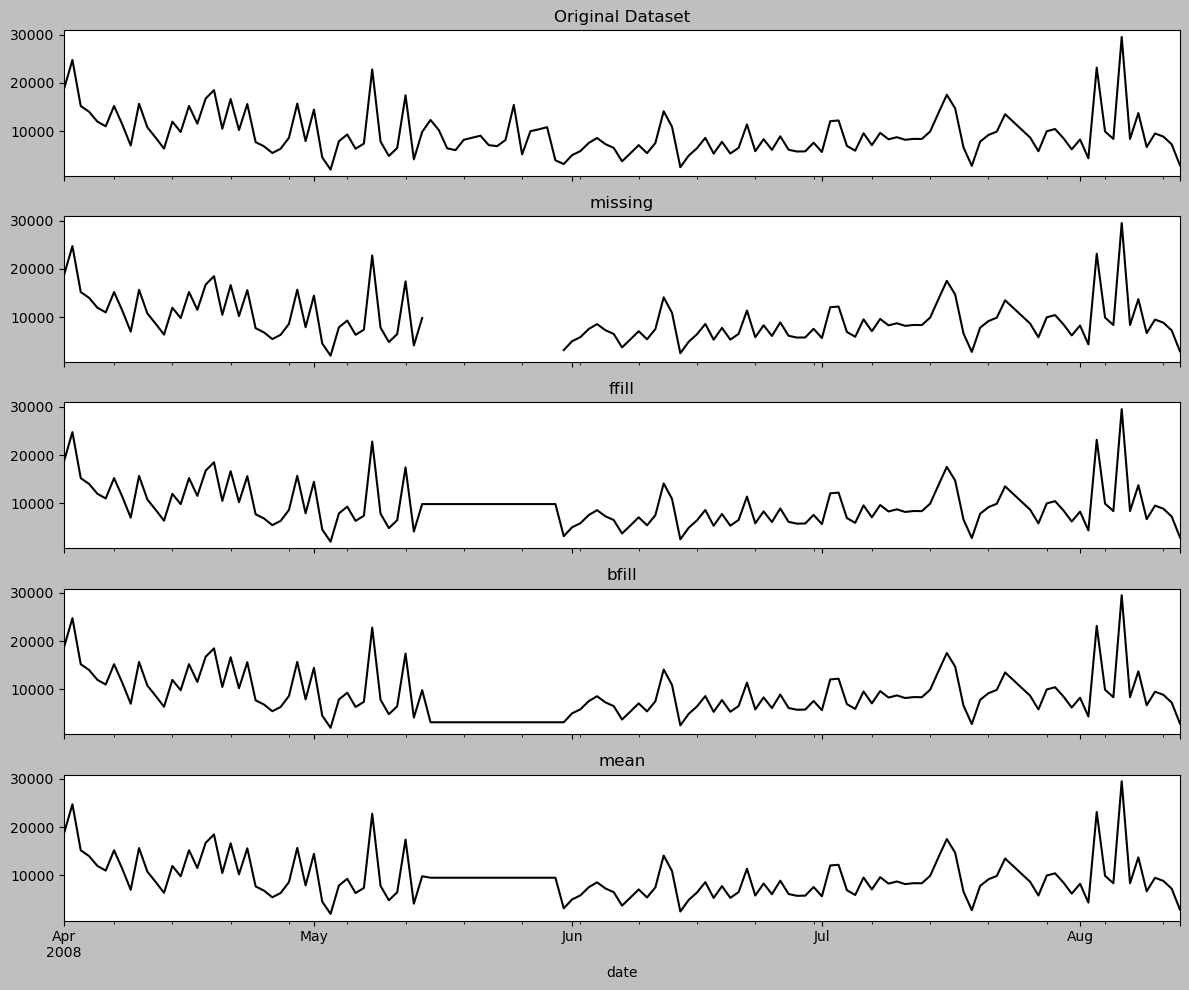

In [140]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

In [141]:
clicks_missing.loc['2008-05-10':'2008-05-18']

,price,location,clicks,ffill,bfill,mean
date,,,,,,
2008-05-10,42.576299,1,4863.0,4863.0,4863.0,4863.000000
2008-05-11,43.405890,5,6511.0,6511.0,6511.0,6511.000000
2008-05-12,43.258326,2,17426.0,17426.0,17426.0,17426.000000
2008-05-13,42.714479,2,4160.0,4160.0,4160.0,4160.000000
2008-05-14,43.372786,5,9841.0,9841.0,9841.0,9841.000000
2008-05-15,42.517755,2,NaN,9841.0,3194.0,9530.336134
2008-05-16,44.011009,2,NaN,9841.0,3194.0,9530.336134
2008-05-17,42.530303,2,NaN,9841.0,3194.0,9530.336134
2008-05-18,42.565698,5,NaN,9841.0,3194.0,9530.336134


In [144]:
clicks_missing.loc['2008-05-30':'2008-06-15']

,price,location,clicks,ffill,bfill,mean
date,,,,,,
2008-05-30,44.558011,5,NaN,9841.0,3194.0,9530.336134
2008-05-31,43.100427,2,3194.0,3194.0,3194.0,3194.000000
2008-06-01,42.875000,2,5038.0,5038.0,5038.0,5038.000000
2008-06-02,43.406951,2,5879.0,5879.0,5879.0,5879.000000
2008-06-03,42.957505,5,7563.0,7563.0,7563.0,7563.000000
2008-06-04,42.930399,2,8584.0,8584.0,8584.0,8584.000000
2008-06-05,42.801887,2,7315.0,7315.0,7315.0,7315.000000
2008-06-06,43.740476,2,6541.0,6541.0,6541.0,6541.000000
2008-06-07,43.823729,1,3755.0,3755.0,3755.0,3755.000000


In [146]:
clicks_missing[clicks_missing['clicks'].isna()]

,price,location,clicks,ffill,bfill,mean
date,,,,,,
2008-05-15,42.517755,2,NaN,9841.0,3194.0,9530.336134
2008-05-16,44.011009,2,NaN,9841.0,3194.0,9530.336134
2008-05-17,42.530303,2,NaN,9841.0,3194.0,9530.336134
2008-05-18,42.565698,5,NaN,9841.0,3194.0,9530.336134
2008-05-19,43.892996,2,NaN,9841.0,3194.0,9530.336134
2008-05-20,43.247706,2,NaN,9841.0,3194.0,9530.336134
2008-05-21,44.106289,1,NaN,9841.0,3194.0,9530.336134
2008-05-22,43.810714,1,NaN,9841.0,3194.0,9530.336134
2008-05-23,43.620802,1,NaN,9841.0,3194.0,9530.336134


### There is More

In [149]:
clicks_missing = read_dataset(folder, 'clicks_missing_more.csv', 'date', index=True)
clicks_missing.isna().sum()

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36646/3901072104.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(folder / file,


price        5
location     6
clicks      16
dtype: int64

**passing a dictionary**

In [152]:
values = {'clicks': clicks_missing['clicks'].median(), 
         'price': clicks_missing['price'].mean(),
         'location': clicks_missing['location'].mode()}

In [154]:
clicks_missing.fillna(value=values, inplace=True)
clicks_missing.isna().sum()

price       0
location    6
clicks      0
dtype: int64

**passing a DataFrame**

In [157]:
clicks_missing = read_dataset(folder, 'clicks_missing_more.csv', 'date', index=True)
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date', index=True)

clicks_missing.fillna(value=clicks_original, inplace=True)
clicks_missing.isna().sum()

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36646/3901072104.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(folder / file,


price       0
location    0
clicks      0
dtype: int64

# Recipe 3: Handling Missing Data with Univariate Imputation using Scikit-Learn
* Using Sckit-Learn `SimpleImputer`

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from pathlib import Path

In [161]:
folder = Path('../../datasets/Ch7/')

co2_original = read_dataset(folder, 
                            'co2_original.csv', 'year', index=True)
co2_missing = read_dataset(folder, 
                           'co2_missing_only.csv', 'year', index=True)
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date', index=True)

In [162]:
strategy = [
    ('Mean Strategy', 'mean'),
    ('Median Strategy', 'median'),
    ('Most Frequent Strategy', 'most_frequent')
]

In [163]:
co2_vals = co2_missing['co2'].values.reshape(-1,1)
clicks_vals = clicks_missing['clicks'].values.reshape(-1,1)

for s_name, s in strategy:
    co2_missing[s_name] = (
        SimpleImputer(missing_values=pd.NA, 
                      strategy=s).fit_transform(co2_vals))
    clicks_missing[s_name] = (
        SimpleImputer(missing_values=pd.NA, 
                      strategy=s).fit_transform(clicks_vals))

In [164]:
_ = rmse_score(co2_original, co2_missing, 'co2')

RMSE for Mean Strategy: 0.7156383637041684
RMSE for Median Strategy: 0.802942160685986
RMSE for Most Frequent Strategy: 1.1245663822743381


In [165]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for Mean Strategy: 997.7600138929953
RMSE for Median Strategy: 959.3580492530756
RMSE for Most Frequent Strategy: 1097.6425985146868


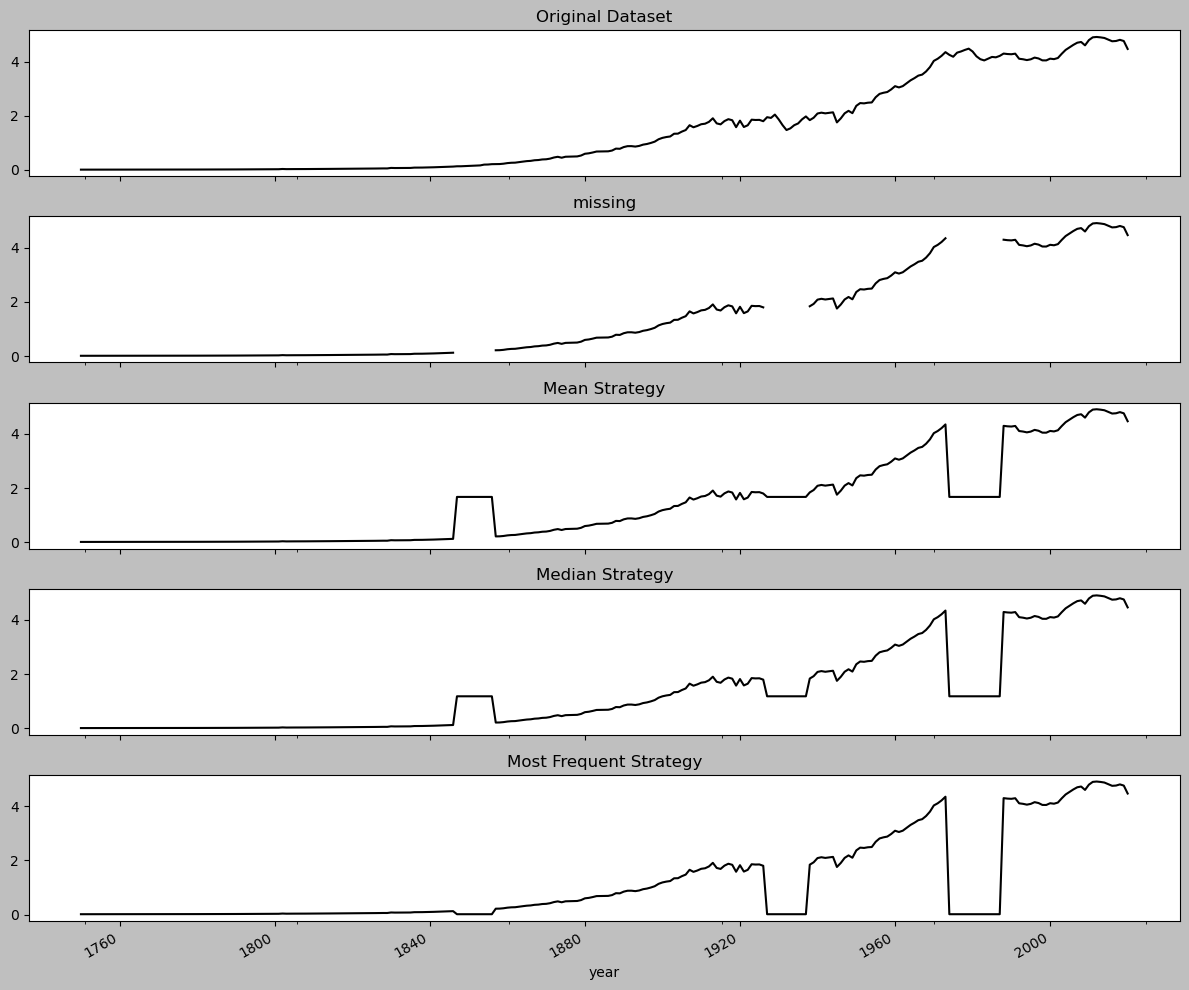

In [166]:
plot_dfs(co2_original, co2_missing, 'co2')

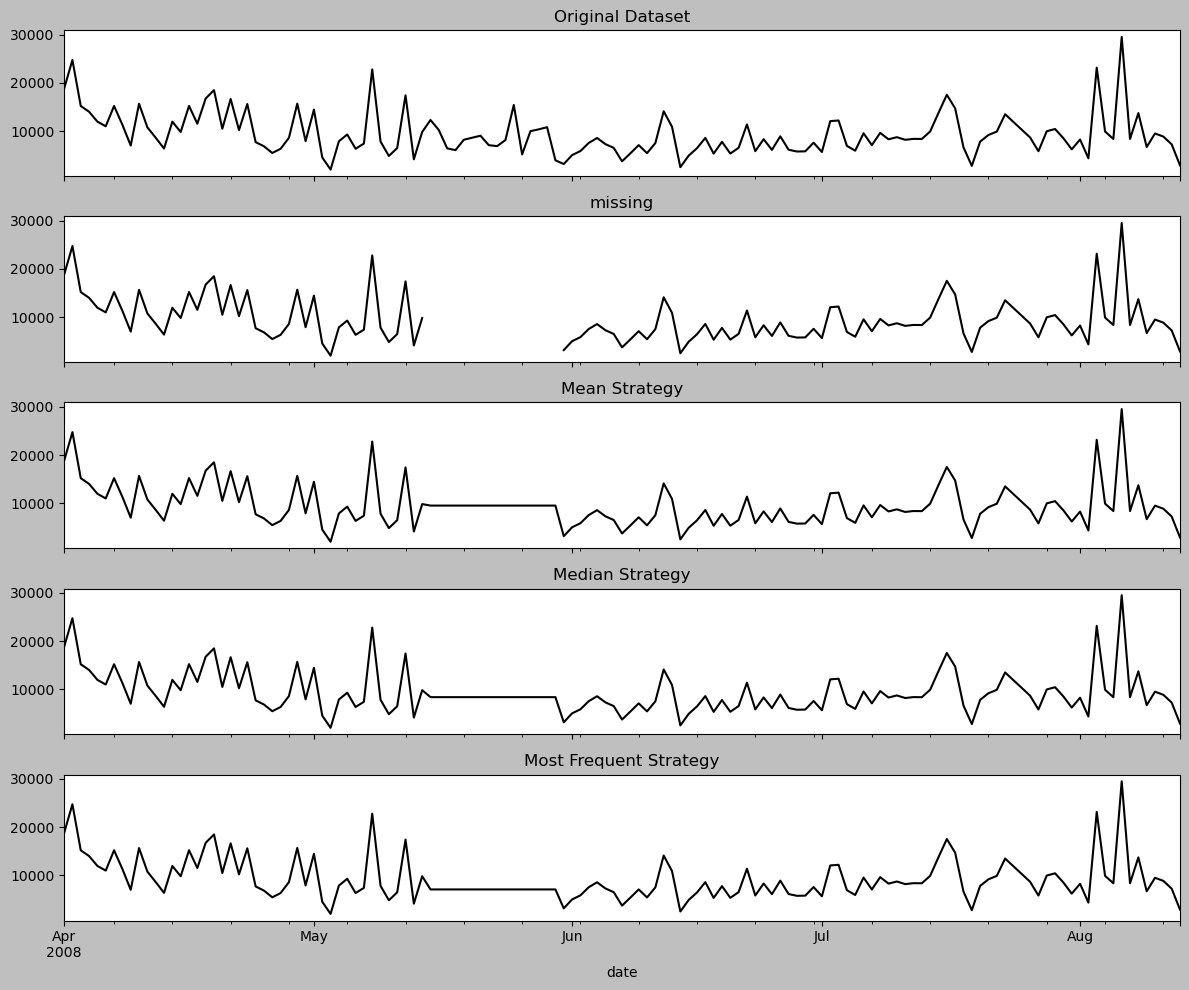

In [174]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

In [176]:
avg = co2_missing['co2'].mean()
co2_missing['pandas_fillna'] = co2_missing['co2'].fillna(avg)

In [178]:
co2_missing

,co2,Mean Strategy,Median Strategy,Most Frequent Strategy,pandas_fillna
year,,,,,
1750-01-01,0.0125,0.0125,0.0125,0.0125,0.0125
1760-01-01,0.0128,0.0128,0.0128,0.0128,0.0128
1770-01-01,0.0150,0.0150,0.0150,0.0150,0.0150
1780-01-01,0.0169,0.0169,0.0169,0.0169,0.0169
1790-01-01,0.0206,0.0206,0.0206,0.0206,0.0206
...,...,...,...,...,...
2016-01-01,4.7496,4.7496,4.7496,4.7496,4.7496
2017-01-01,4.7595,4.7595,4.7595,4.7595,4.7595
2018-01-01,4.8022,4.8022,4.8022,4.8022,4.8022


In [180]:
cols = ['co2', 'Mean Strategy', 'pandas_fillna']
_ = rmse_score(co2_original, co2_missing[cols], 'co2')

RMSE for Mean Strategy: 0.7156383637041684
RMSE for pandas_fillna: 0.7156383637041684


In [182]:
pd.Series([pd.NA])

0    <NA>
dtype: object

In [184]:
pd.Series([np.nan])

0   NaN
dtype: float64

In [186]:
import pandas as pd
import numpy as np

data = {
    'A': [1, 2, np.nan, 4],
    'B': [np.nan, 2, 3, 4],
    'C': [1, np.nan, np.nan, 4]
}
sales_report_data = pd.DataFrame(data)
print(sales_report_data)

     A    B    C
0  1.0  NaN  1.0
1  2.0  2.0  NaN
2  NaN  3.0  NaN
3  4.0  4.0  4.0


In [188]:
sales_report_data.fillna(sales_report_data.mean(), inplace=True)
print(sales_report_data)

          A    B    C
0  1.000000  3.0  1.0
1  2.000000  2.0  2.5
2  2.333333  3.0  2.5
3  4.000000  4.0  4.0


## There is more

In [191]:
co2_missing = read_dataset(folder, 
                           'co2_missing_only.csv', 'year', index=True)
co2_vals = co2_missing['co2'].values.reshape(-1,1)


In [194]:
imputer = SimpleImputer(strategy='mean', add_indicator=True)

In [196]:
imputer.fit(co2_vals)

SimpleImputer(add_indicator=True)

In [198]:
imputer.get_params()

{'add_indicator': True,
 'copy': True,
 'fill_value': None,
 'keep_empty_features': False,
 'missing_values': nan,
 'strategy': 'mean'}

In [200]:
imputer.indicator_

MissingIndicator(error_on_new=False)

In [202]:
co2_missing[['imputed', 'indicator']] = (imputer.transform(co2_vals))
print(co2_missing.head(5))

               co2  imputed  indicator
year                                  
1750-01-01  0.0125   0.0125        0.0
1760-01-01  0.0128   0.0128        0.0
1770-01-01  0.0150   0.0150        0.0
1780-01-01  0.0169   0.0169        0.0
1790-01-01  0.0206   0.0206        0.0


In [204]:
print(co2_missing.loc['1855-01-01':].head())

               co2   imputed  indicator
year                                   
1855-01-01     NaN  1.673262        1.0
1856-01-01     NaN  1.673262        1.0
1857-01-01  0.2163  0.216300        0.0
1858-01-01  0.2192  0.219200        0.0
1859-01-01  0.2320  0.232000        0.0


# Recipe 4: Handling Missing Data with Multivariate Imputation
* In this recipe, you will be working with the Clickstream dataset since it has additional variables (clicks, price, and location columns) to perform multivariate imputation for clicks.
* Using Scikit-Learn `IterativeImputer`
* Using statsmodels `MICE` implementation

In [207]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

In [208]:
folder = Path('../../datasets/Ch7/')

clicks_original = read_dataset(folder, 
                            'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 
                            'clicks_missing.csv', 'date', index=True)

In [209]:
clicks_missing.isna().sum()

price        0
location     0
clicks      16
dtype: int64

### Using IterativeImputer

In [211]:
regressors = [
    ('bayesianRidge', BayesianRidge()),
    ('extra_trees', ExtraTreesRegressor(n_estimators=50)),
    ('bagging', BaggingRegressor(n_estimators=50)),
    ('elastic_net', ElasticNet()),
    ('linear_regression', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=3))
]


In [212]:
clicks_vals = clicks_missing.iloc[:,0:3].values

for reg_name, reg in regressors:
    est = IterativeImputer(
                random_state=15,
                estimator=reg).fit(clicks_vals)
    clicks_missing[reg_name] = est.transform(clicks_vals)[: , 2]   
    

/opt/anaconda3/envs/ts/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/ts/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [213]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for bayesianRidge: 949.4393973455852
RMSE for extra_trees: 1522.8443054281072
RMSE for bagging: 1303.763690405873
RMSE for elastic_net: 945.40752093431
RMSE for linear_regression: 938.941983142718
RMSE for knn: 1336.8798392251822


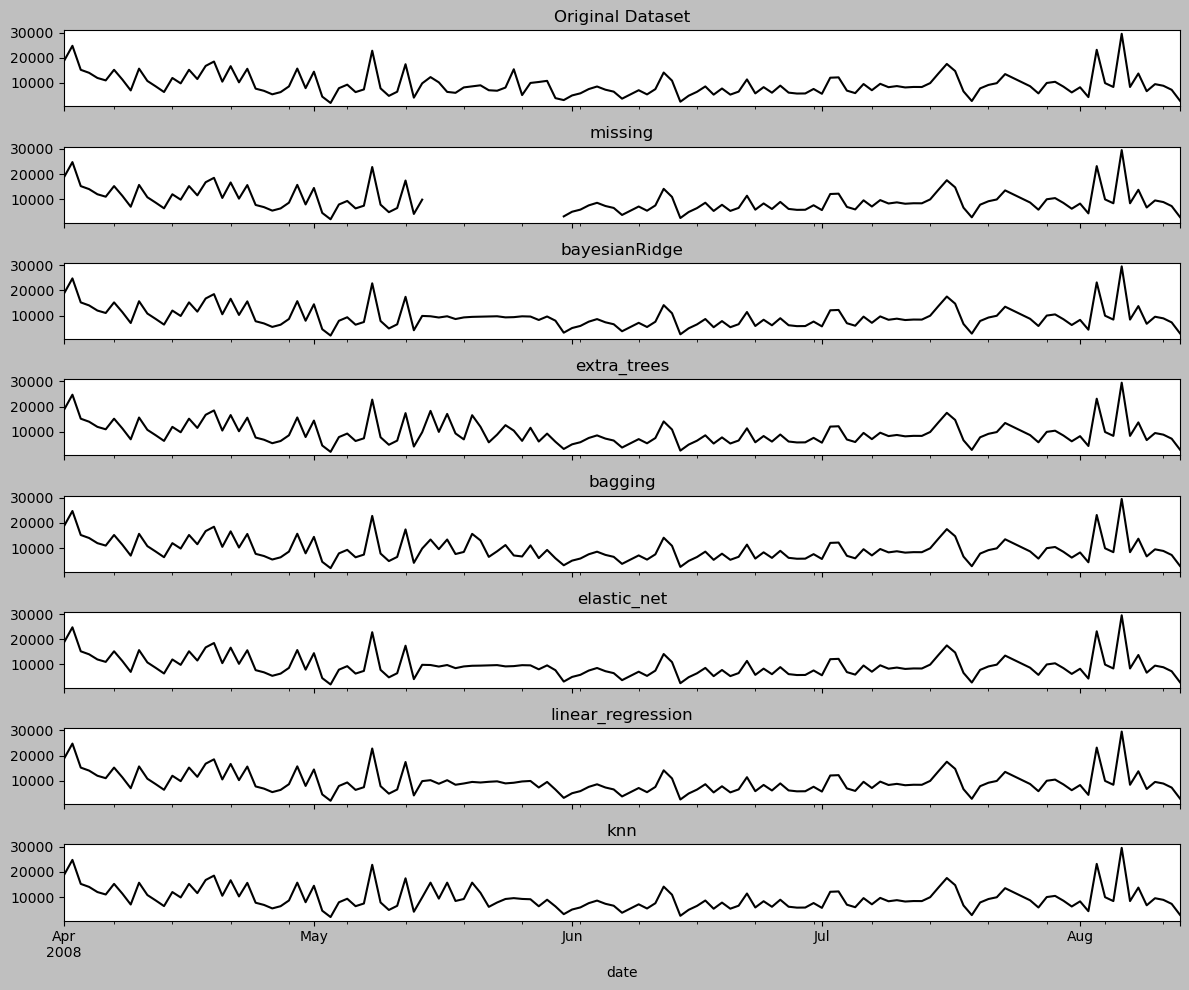

In [220]:

plot_dfs(clicks_original, clicks_missing, 'clicks')

### Using KNNImputer

In [223]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=3)
clicks_missing['knn_imputer'] = knn_imputer.fit_transform(clicks_vals)[: , 2]  

In [225]:
clicks_missing

,price,location,clicks,bayesianRidge,extra_trees,bagging,elastic_net,linear_regression,knn,knn_imputer
date,,,,,,,,,,
2008-04-01,43.155647,2,18784.0,18784.0,18784.0,18784.0,18784.0,18784.0,18784.0,18784.0
2008-04-02,43.079056,1,24738.0,24738.0,24738.0,24738.0,24738.0,24738.0,24738.0,24738.0
2008-04-03,43.842609,2,15209.0,15209.0,15209.0,15209.0,15209.0,15209.0,15209.0,15209.0
2008-04-04,43.312376,1,14018.0,14018.0,14018.0,14018.0,14018.0,14018.0,14018.0,14018.0
2008-04-05,43.941176,1,11974.0,11974.0,11974.0,11974.0,11974.0,11974.0,11974.0,11974.0
...,...,...,...,...,...,...,...,...,...,...
2008-08-09,44.182033,1,6716.0,6716.0,6716.0,6716.0,6716.0,6716.0,6716.0,6716.0
2008-08-10,43.608260,1,9523.0,9523.0,9523.0,9523.0,9523.0,9523.0,9523.0,9523.0
2008-08-11,43.553363,1,8881.0,8881.0,8881.0,8881.0,8881.0,8881.0,8881.0,8881.0


In [227]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for bayesianRidge: 949.4393973455852
RMSE for extra_trees: 1522.8443054281072
RMSE for bagging: 1303.763690405873
RMSE for elastic_net: 945.40752093431
RMSE for linear_regression: 938.941983142718
RMSE for knn: 1336.8798392251822
RMSE for knn_imputer: 1336.8798392251822


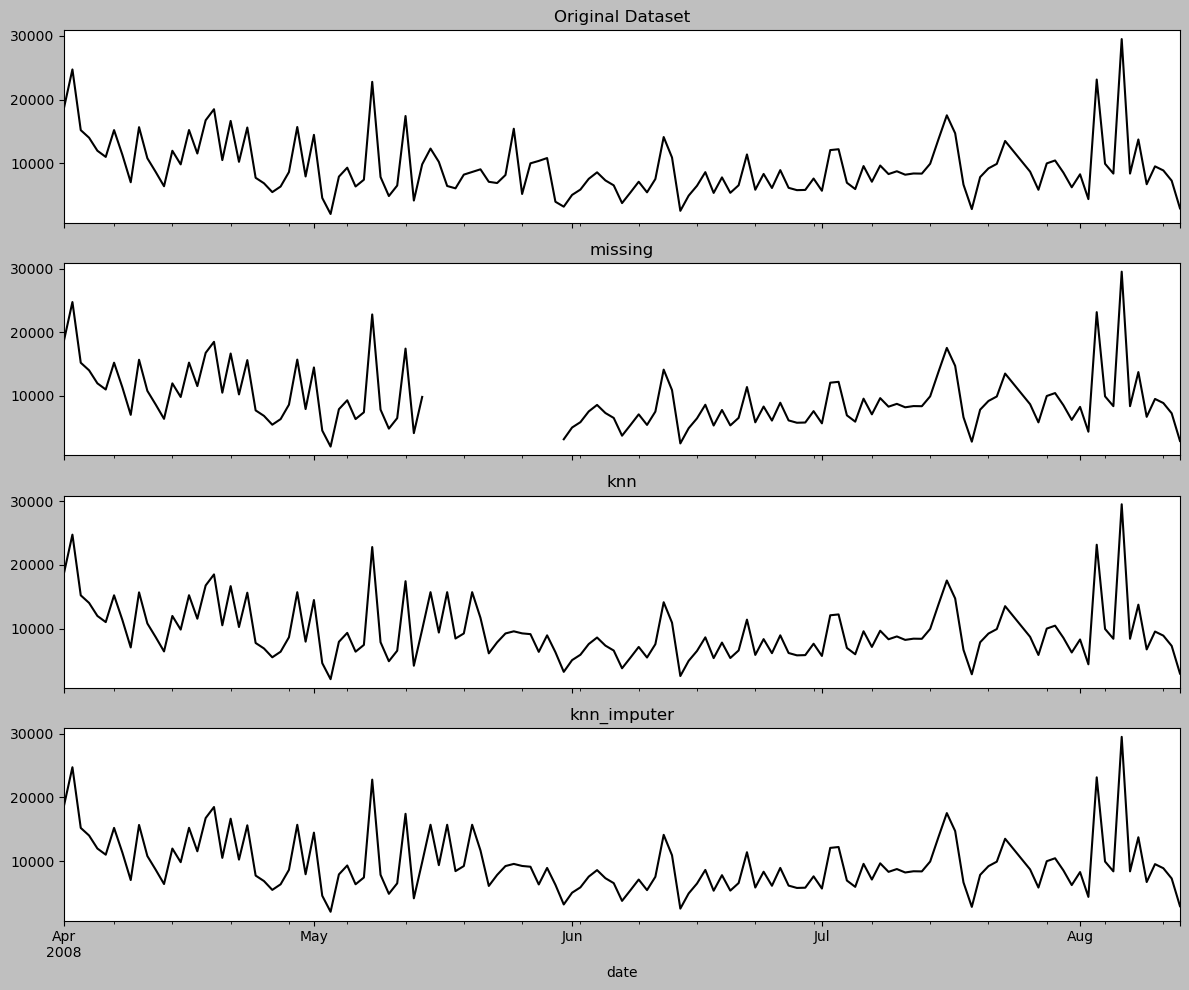

In [229]:
plot_dfs(clicks_original, clicks_missing[['clicks','knn','knn_imputer']], 'clicks')

### There is more

In [233]:
from statsmodels.imputation.mice import MICEData
import statsmodels.api as sm

In [234]:
# Specify columns to include in the MICEData object
cols = ['price', 'location', 'clicks']

# Create a MICEData object with specified columns from the dataset
mice_data = MICEData(clicks_missing[cols], 
                     k_pmm=20,
                     perturbation_method='gaussian')

# Set imputer for 'clicks' using 'price','location', 'clicks'
mice_data.set_imputer('clicks', formula='price + location + clicks', model_class=sm.OLS)

# Perform 20 iterations of imputation
mice_data.update_all(n_iter=20)

In [235]:
clicks_missing['MICE']  = mice_data.data['clicks'].values.tolist()

In [236]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for bayesianRidge: 949.4393973455852
RMSE for extra_trees: 1522.8443054281072
RMSE for bagging: 1303.763690405873
RMSE for elastic_net: 945.40752093431
RMSE for linear_regression: 938.941983142718
RMSE for knn: 1336.8798392251822
RMSE for knn_imputer: 1336.8798392251822
RMSE for MICE: 941.9499829451511


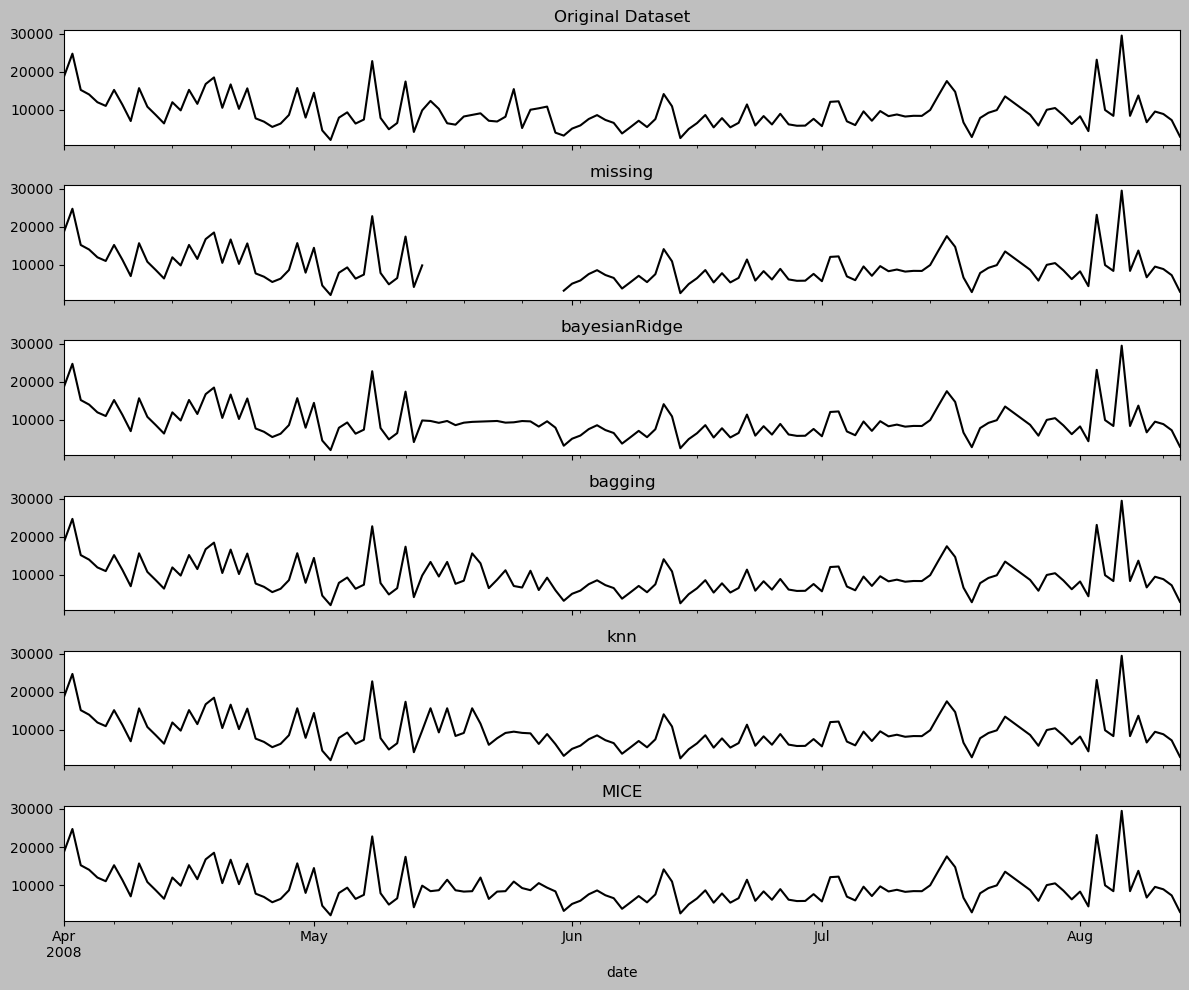

In [237]:
cols = ['clicks','bayesianRidge', 'bagging', 'knn', 'MICE']
plot_dfs(clicks_original, clicks_missing[cols], 'clicks')

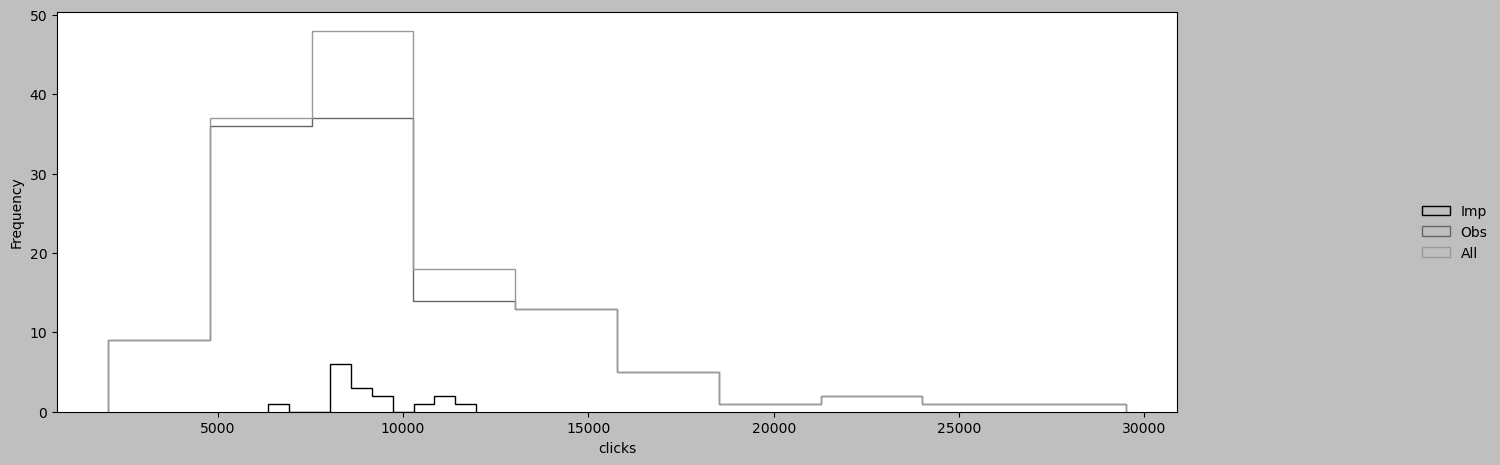

In [238]:
_ = mice_data.plot_imputed_hist('clicks')

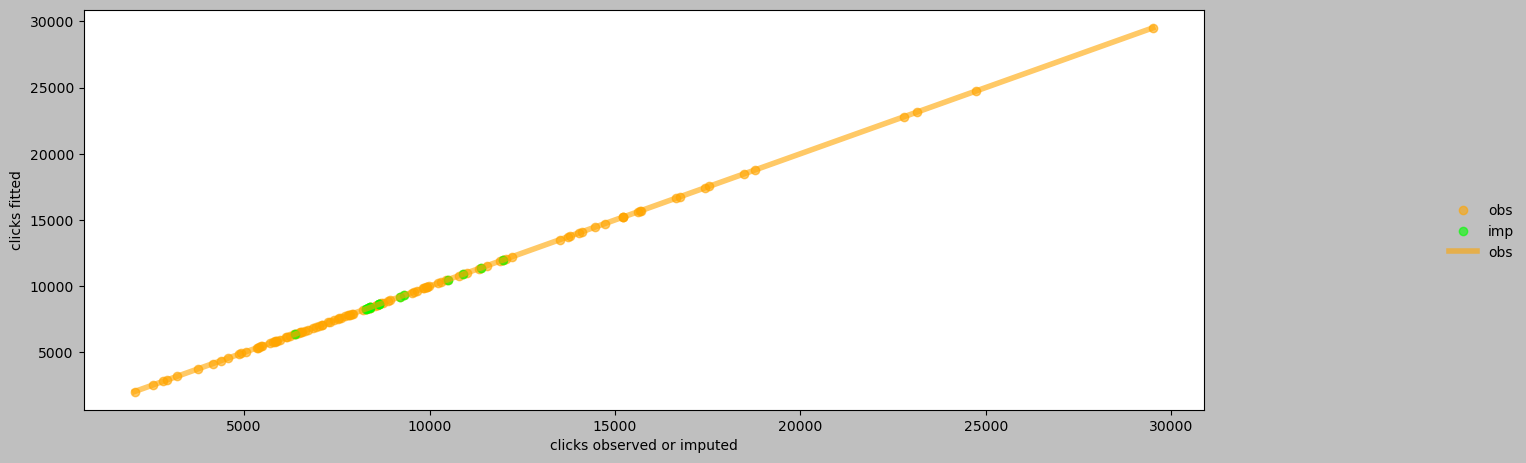

In [239]:
# mice_data = MICEData(clicks_missing[cols], 
#                      perturbation_method='gaussian')
# mice_data.update_all(n_iter=10)
_ = mice_data.plot_fit_obs('clicks')

# Recipe 4: Handling Missing Data with Interpolation
* In this recipe, you will use the`.interpolate()` function to examine different interpolation methods, including `linear`, `polynomial`, `quadratic`, `nearest`, and `spline`.

In [248]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [250]:
folder = Path('../../datasets/Ch7/')

co2_original = read_dataset(folder, 
                            'co2_original.csv', 'year', index=True)
co2_missing = read_dataset(folder, 
                           'co2_missing_only.csv', 'year', index=True)
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date', index=True)

In [252]:
co2_missing.interpolate()

,co2
year,
1750-01-01,0.0125
1760-01-01,0.0128
1770-01-01,0.0150
1780-01-01,0.0169
1790-01-01,0.0206
...,...
2016-01-01,4.7496
2017-01-01,4.7595
2018-01-01,4.8022


In [254]:
interpolations = [
    'linear',
    'quadratic',
    'nearest',
    'cubic'
]

for intp in interpolations:
    co2_missing[intp] = co2_missing['co2'].interpolate(method=intp)
    clicks_missing[intp] = clicks_missing['clicks'].interpolate(method=intp)


co2_missing['spline'] = \
    co2_missing['co2'].interpolate(method='spline', order=2)
co2_missing['polynomial'] = \
    co2_missing['co2'].interpolate(method='polynomial',order=2)


clicks_missing['spline'] = \
    clicks_missing['clicks'].interpolate(method='spline',order=2)
clicks_missing['polynomial'] = \
    clicks_missing['clicks'].interpolate(method='polynomial',order=2)



In [256]:
_ = rmse_score(co2_original, co2_missing, 'co2')

RMSE for linear: 0.05507291327761665
RMSE for quadratic: 0.08367561505614354
RMSE for nearest: 0.05385422309469095
RMSE for cubic: 0.08373627305833194
RMSE for spline: 0.18786023475414115
RMSE for polynomial: 0.08367561505614354


In [258]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for linear: 1329.1448378562811
RMSE for quadratic: 5224.641260626975
RMSE for nearest: 1706.1853705030173
RMSE for cubic: 6199.304875782831
RMSE for spline: 5222.9229934486475
RMSE for polynomial: 5224.641260626975


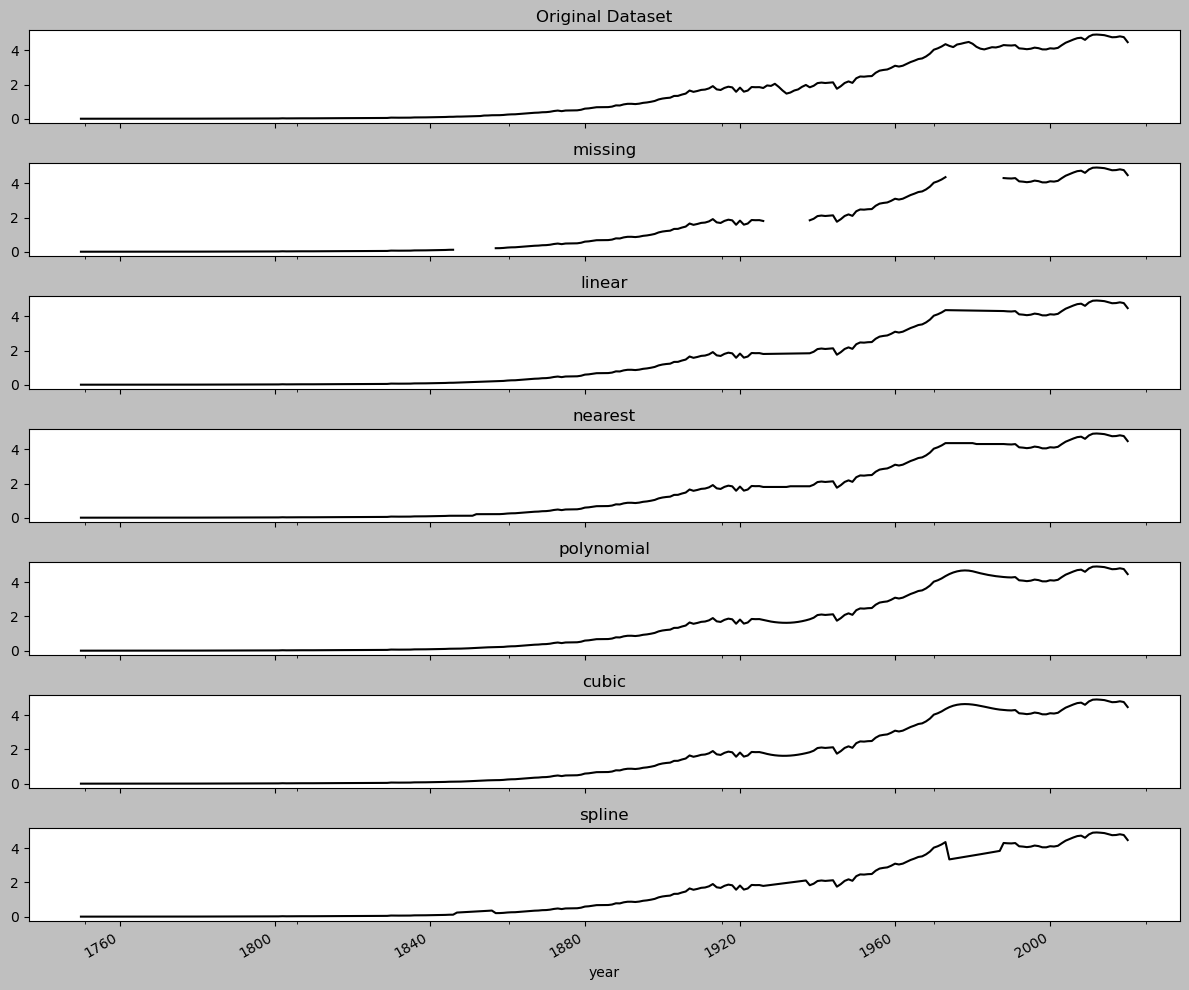

In [260]:
cols = ['co2', 'linear', 'nearest', 'polynomial', 'cubic', 'spline']
plot_dfs(co2_original, co2_missing[cols], 'co2')

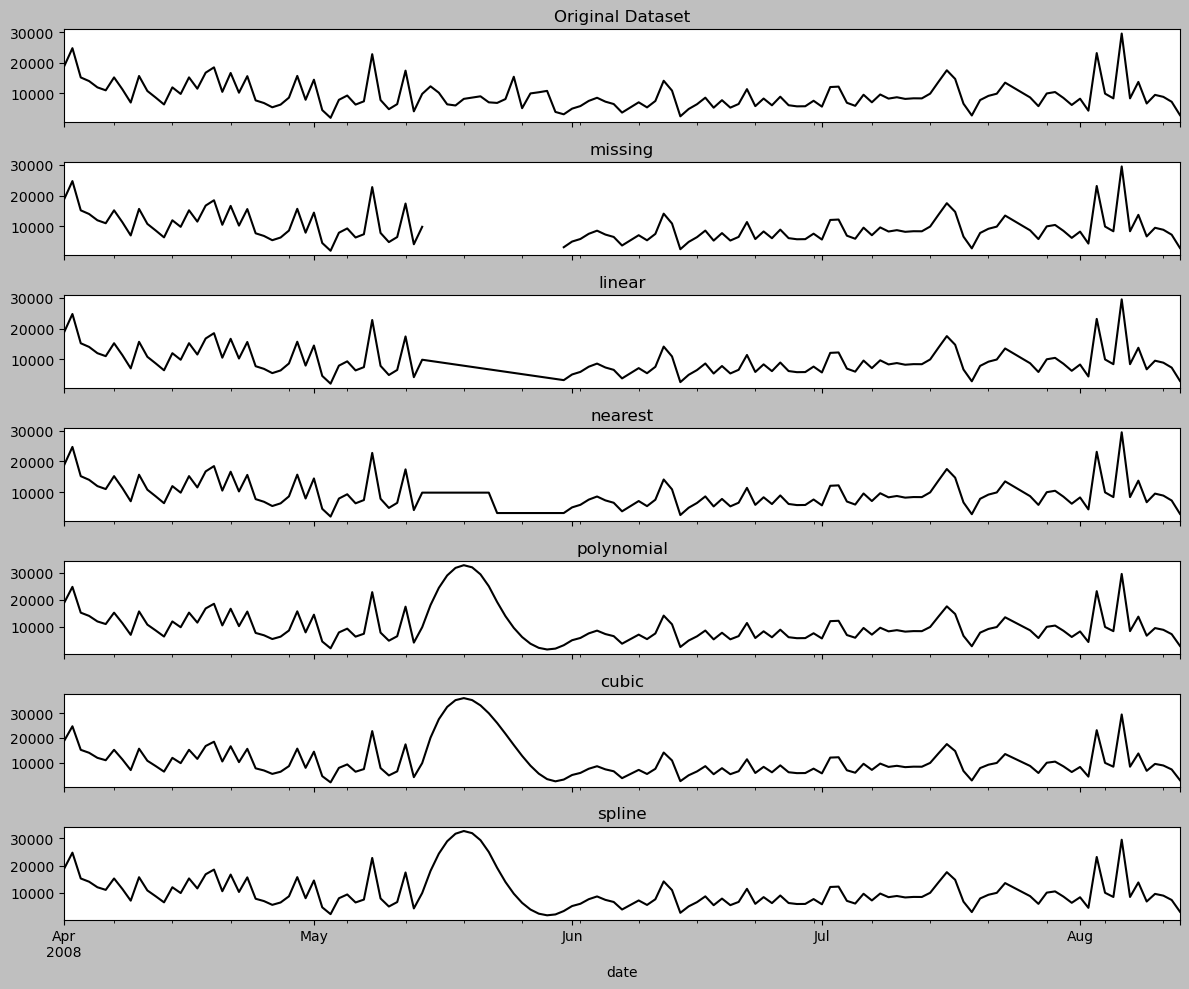

In [261]:
cols = ['clicks', 'linear', 'nearest', 'polynomial', 'cubic', 'spline']
plot_dfs(clicks_original, clicks_missing[cols], 'clicks')

### How it works

In [264]:
clicks_missing['clicks'].isna().sum()

np.int64(16)

In [265]:
example = clicks_missing['clicks'].interpolate(limit = 5)

In [269]:
example.isna().sum()

np.int64(11)

In [271]:
clicks_missing['clicks']['2008-05-15':].head(10)

date
2008-05-15   NaN
2008-05-16   NaN
2008-05-17   NaN
2008-05-18   NaN
2008-05-19   NaN
2008-05-20   NaN
2008-05-21   NaN
2008-05-22   NaN
2008-05-23   NaN
2008-05-24   NaN
Name: clicks, dtype: float64

In [273]:
example['2008-05-15':].head(10)

date
2008-05-15    9450.0
2008-05-16    9059.0
2008-05-17    8668.0
2008-05-18    8277.0
2008-05-19    7886.0
2008-05-20       NaN
2008-05-21       NaN
2008-05-22       NaN
2008-05-23       NaN
2008-05-24       NaN
Name: clicks, dtype: float64

### There is more

In [276]:
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date', index=True)

In [278]:
clicks_missing.head()

,price,location,clicks
date,,,
2008-04-01,43.155647,2,18784.0
2008-04-02,43.079056,1,24738.0
2008-04-03,43.842609,2,15209.0
2008-04-04,43.312376,1,14018.0
2008-04-05,43.941176,1,11974.0


In [280]:
clicks_missing['clicks']['2008-05-14':]

date
2008-05-14    9841.0
2008-05-15       NaN
2008-05-16       NaN
2008-05-17       NaN
2008-05-18       NaN
               ...  
2008-08-09    6716.0
2008-08-10    9523.0
2008-08-11    8881.0
2008-08-12    7272.0
2008-08-13    2922.0
Name: clicks, Length: 92, dtype: float64

In [282]:
clicks_missing.shape

(135, 3)